<a href="https://colab.research.google.com/github/vaishwagh/webfeed/blob/main/BE_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Architecture Diagram

![architecture.png](attachment:architecture.png)

### Import Libraries

In [15]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog, WORD, INSERT, END, DISABLED
from PIL import Image
from PIL import ImageTk
from pandas import read_csv

## DATA CLEANING AND PREPROCESSING

In [10]:
dataset_path = "/content/drive/MyDrive/citrus/Leaves"
disease_names = sorted(os.listdir(dataset_path))
num_classes = len(disease_names)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### CHECKING CLASSES PRESENT IN DATASET

In [11]:
disease_names

['Black spot', 'Melanose', 'canker', 'greening', 'healthy']

## Count of Images

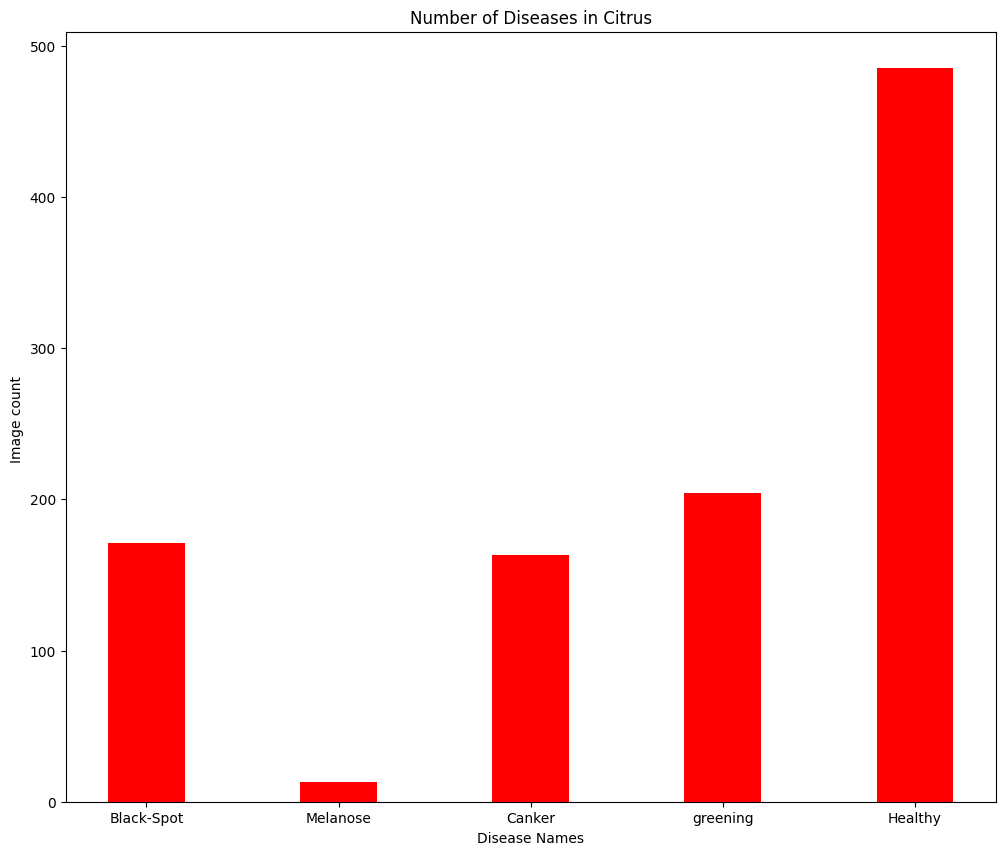

In [7]:
data = {'Black-Spot':171, 'Melanose':13, 'Canker':163,
        'greening':204,'Healthy':485}
Labels = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (12, 10))
plt.bar(Labels, values, color ='red',
        width = 0.4)
plt.xlabel("Disease Names")
plt.ylabel("Image count ")
plt.title("Number of Diseases in Citrus")
plt.show();

### PLOTTING THE IMAGES

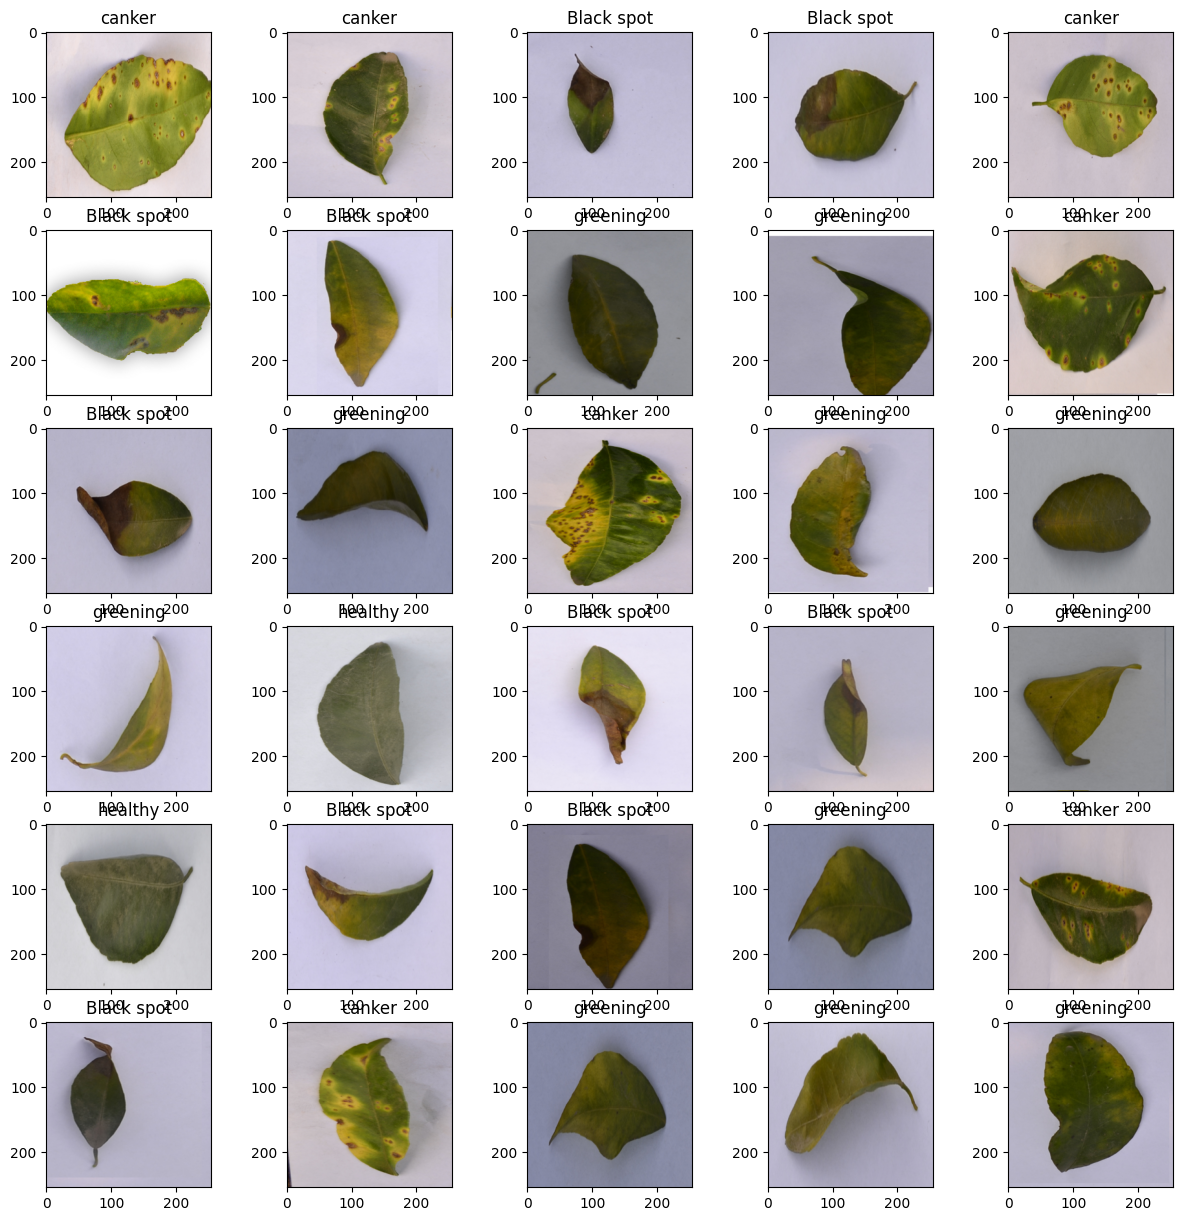

Found 609 files belonging to 5 classes.


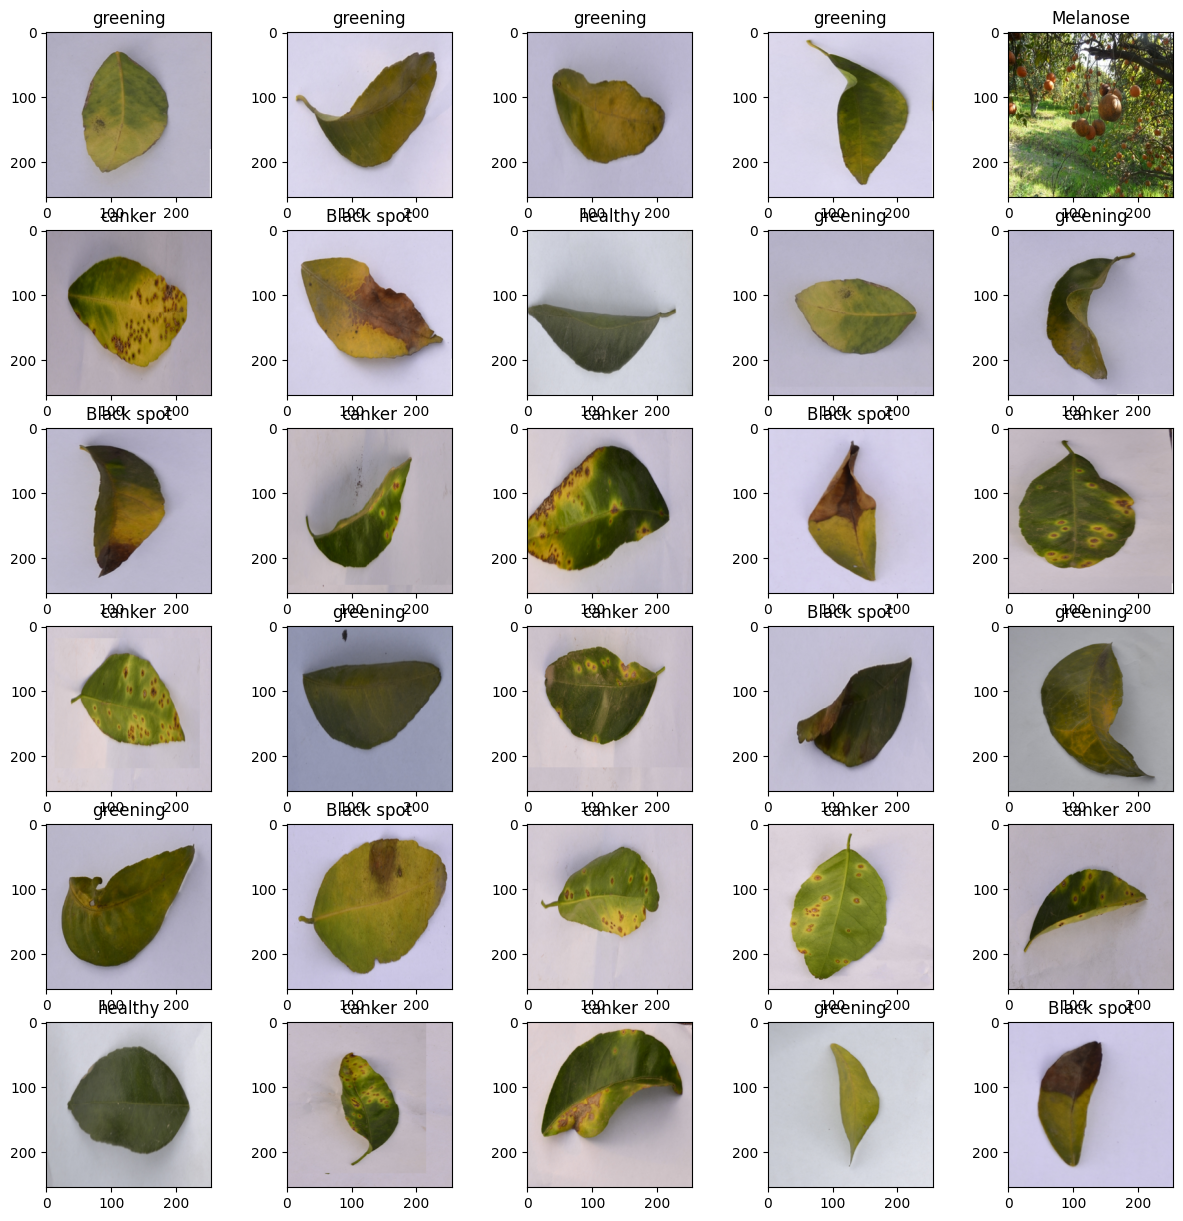

In [18]:
# Assuming dataset_path is already defined
dataset = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  labels='inferred',
  label_mode='int',
  image_size=(255, 255), # Use the same size as your model input
  interpolation='nearest',
  batch_size=32,
  shuffle=True
)

plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
  for i in range(30):
    ax = plt.subplot(6,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(dataset.class_names[label_batch[i]])
    plt.axis("ON")

### DEFINING DATA FOR TRAINING AND VALIDATION

In [19]:
# Create data generators for training and validation data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
training_data = datagen.flow_from_directory(dataset_path, target_size=(255,255),
                                              batch_size=32, class_mode='categorical',
                                              subset='training')
validation_data = datagen.flow_from_directory(dataset_path, target_size=(255,255),
                                                   batch_size=32, class_mode='categorical',
                                                   subset='validation')

Found 490 images belonging to 5 classes.
Found 119 images belonging to 5 classes.


In [20]:
print("Batches of training data:- ",len(training_data))

Batches of training data:-  16


In [21]:
print("Batches of validation data :- ",len(validation_data))

Batches of validation data :-  4


### MODEL BUILDING

In [23]:
 resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(255, 255),
  layers.Rescaling(1./255),
])

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [26]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32, 255, 255, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax'),
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.build(input_shape=(32, 255, 255, 3))

In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 124, 124, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',patience=10,
    mode="max"
)

In [31]:
hist = model.fit(
    training_data,
    batch_size=32,
    validation_data=validation_data,callbacks=early_stopping,
    epochs=2,verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.2501 - loss: 1.5566 - val_accuracy: 0.2689 - val_loss: 1.3890
Epoch 2/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.2657 - loss: 1.4479 - val_accuracy: 0.3361 - val_loss: 1.3703


## MODEL EVALUATION

In [32]:
# Evaluate the model on the validation dataset
val_loss, val_acc = model.evaluate(validation_data)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3063 - loss: 1.4016
Validation loss: 1.370347261428833
Validation accuracy: 0.3361344635486603


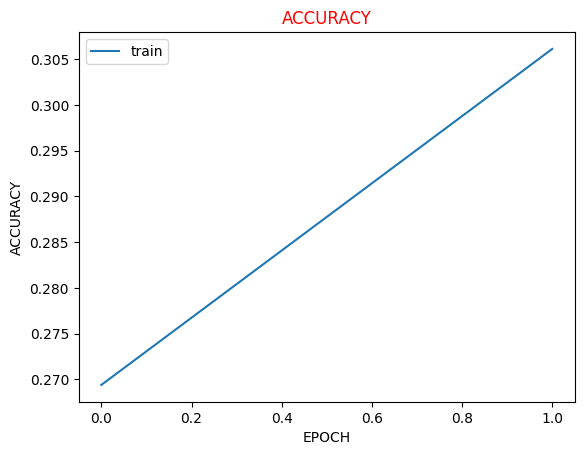

In [33]:
# accuracy of the model
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.title("ACCURACY",color="red")
plt.ylabel("ACCURACY")
plt.xlabel("EPOCH")
plt.legend(['train'],loc='upper left')
plt.show()

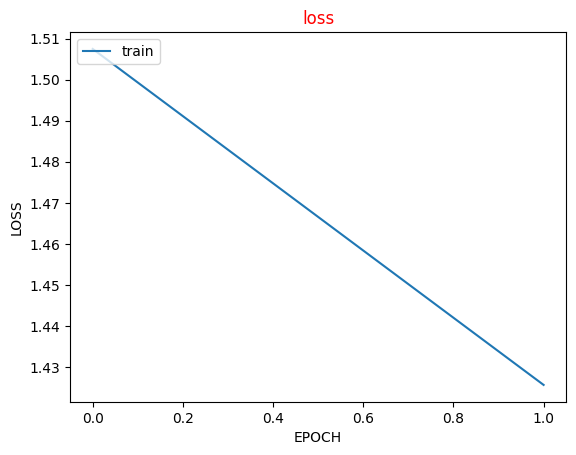

In [34]:
# loss of the model
plt.plot(hist.history['loss'])
plt.title("loss",color="red")
plt.ylabel("LOSS")
plt.xlabel("EPOCH")
plt.legend(['train'],loc='upper left')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 939ms/step


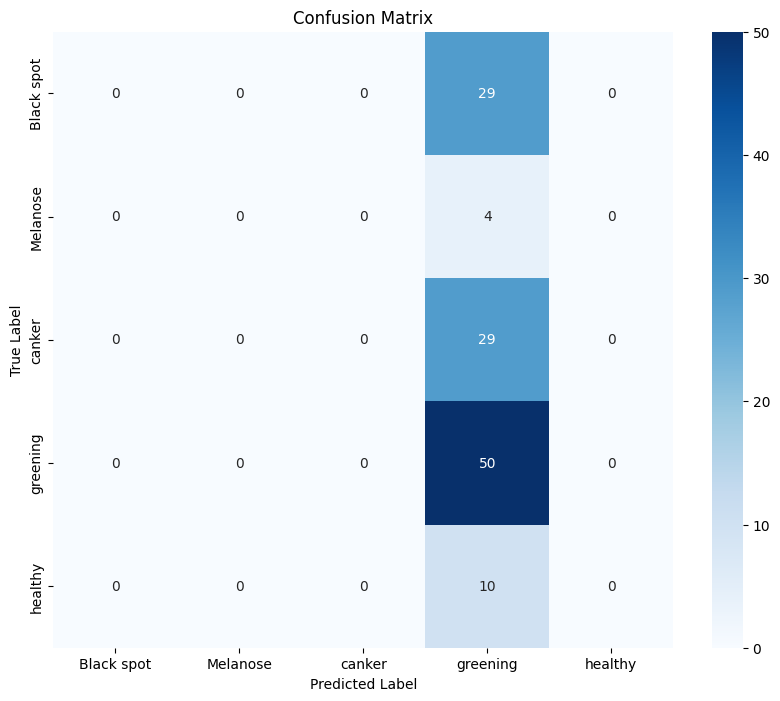

In [37]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for better visualization
from PIL import Image
import tensorflow as tf # Import tensorflow

# Define the dataset folder path
dataset_folder = "/content/drive/MyDrive/citrus/Leaves"

# Create a list to store image paths and their corresponding labels
image_paths = []
labels = []

# Iterate through the subfolders and collect image paths with their labels
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Convert labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, encoded_labels, test_size=0.2, random_state=42)

# Load images and resize them to the size expected by the model (255x255)
image_size = (255, 255)
X_test_images = [np.array(Image.open(image_path).resize(image_size)) for image_path in X_test]

# Convert the list of images to a numpy array and normalize
X_test_images = np.array(X_test_images).astype('float32') / 255.0

# Predict labels for the test set
# Ensure your model variable is the loaded or trained TensorFlow model
y_pred = model.predict(X_test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
class_names = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [38]:

true_labels = validation_data.classes
num_samples = len(true_labels)
predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
cm

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 988ms/step
Confusion Matrix:


array([[ 0,  0,  0, 34,  0],
       [ 0,  0,  0,  2,  0],
       [ 0,  0,  0, 32,  0],
       [ 0,  0,  0, 40,  0],
       [ 0,  0,  0, 11,  0]])

In [39]:
class_report = classification_report(true_labels, predicted_labels, target_names=disease_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

  Black spot       0.00      0.00      0.00        34
    Melanose       0.00      0.00      0.00         2
      canker       0.00      0.00      0.00        32
    greening       0.34      1.00      0.50        40
     healthy       0.00      0.00      0.00        11

    accuracy                           0.34       119
   macro avg       0.07      0.20      0.10       119
weighted avg       0.11      0.34      0.17       119



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
# Prediction of first 10 labels in testing data
# Use validation_data since testing_data is not defined
y_pre=model.predict(validation_data)
y_class=[np.argmax(i) for i in y_pre]
# print("Predicted Classes :-",y_class[:10])
ls=[]
# Iterate over the first 10 predicted classes
for i in y_class[:10]:
    if i==0:
        ls.append("Back Spot")
    elif i==1:
        ls.append("Canker")
    elif i==2:
        ls.append("Greening")
    elif i==3:
        ls.append("Healthy")
    else:
        ls.append("Mealnose")
print("Predicted Classes :-\n",ls)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Predicted Classes :-
 ['Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy']


In [42]:
model.save('my_model.h5')

## VGG16 MODEL

In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
# Define some hyperparameters
batch_size = 32
img_height = 255
img_width = 255
num_epochs = 1

In [45]:
# Define a CNN model using the VGG16 architecture
model = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_shape=(255,255, 3),
    classes=5
)

In [46]:
# Compile the model with categorical crossentropy loss and Adam optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',patience=10,
    mode="max"
)

In [ ]:
# Train the model on the training dataset
history = model.fit(
    training_data,
    epochs=1,
    validation_data=validation_data,callbacks=early_stopping
)

 9/16 ━━━━━━━━━━━━━━━━━━━━ 9:12 79s/step - accuracy: 0.3249 - loss: 1.4422 

In [49]:

# Evaluate the model on the validation dataset
val_loss, val_acc = model.evaluate(validation_data)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Generate predictions for the validation dataset and compute the confusion matrix
y_true = validation_data.classes
y_pred = model.predict(validation_data).argmax(axis=-1)
conf_matrix = tf.math.confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", conf_matrix)



4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 20s/step - accuracy: 0.2701 - loss: 1.4396
Validation loss: 1.4423657655715942
Validation accuracy: 0.2689075767993927


4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 20s/step
Confusion matrix:
 tf.Tensor(
[[ 0  0 34  0  0]
 [ 0  0  2  0  0]
 [ 0  0 32  0  0]
 [ 0  0 40  0  0]
 [ 0  0 11  0  0]], shape=(5, 5), dtype=int32)


## TESTING

In [50]:
import tkinter as tk
from tkinter import filedialog, INSERT, END, WORD, DISABLED
from PIL import Image, ImageTk
import cv2
import numpy as np
from keras import models
import pandas as pd

form = tk.Tk()
form.geometry("1000x500")
form.title('Fake Review Detection Using Machine Learning')  # This might be misnamed if it's a leaf disease detector
form.resizable(False, False)

my_font1 = ('times', 18, 'bold')
my_font2 = ('times', 15, 'bold')

l1 = tk.Label(form, text='Fake Review Detection Using Machine Learning',
              width=70, font=my_font1, bg='white', fg='green', padx=10, pady=5)
l1.grid(row=1, column=1)

b1 = tk.Button(form, text='Upload Leaf Image',
               width=20, command=lambda: upload_file())
b1.grid(row=3, column=1)

l2 = tk.Label(form)
l2.grid(row=5, column=1)

l3 = tk.Label(form)
l3.grid(row=11, column=1)

l4 = tk.Text(form, wrap=WORD, width=90, height=5, fg="green")
l4.grid(row=20, column=1)
l4.config(state=DISABLED, highlightthickness=0, borderwidth=0, bg='#f0f0f0')

def upload_file():
    global img
    f_types = [('Image Files', '*.txt;*.jpg;*.png')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    if not filename:
        return
    img = Image.open(filename)
    img.save("leaf.png")
    img_resized = img.resize((255, 255))
    img = ImageTk.PhotoImage(img_resized)
    l2.config(image=img)
    l2.image = img

    b3 = tk.Button(form, text='Predict',
                   width=20, command=lambda: prediction())
    b3.grid(row=9, column=1)

def prediction():
    model = models.load_model("my_model.h5")
    class_names = ['Black spot', 'Melanose', 'canker', 'greening', 'healthy']

    img = cv2.imread("leaf.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (255, 255))
    img = np.expand_dims(img, 0)

    weights = model.predict(img)
    img_prediction = weights.argmax(axis=1)[0]
    prediction_result = class_names[img_prediction]

    l3.config(text=f"Prediction: {prediction_result}", font=my_font2, fg="green")

    l4.config(state='normal')
    l4.delete('1.0', END)

    if prediction_result != "healthy":
        try:
            treatments = pd.read_csv("treatments.csv")
            treatment = treatments.loc[treatments['disease'] == prediction_result].values.tolist()
            if treatment:
                l3.config(fg="red")
                l4.insert(INSERT, f"Recommendation(Treatment) : {treatment[0][1]}")
                l4.config(fg="red")
        except Exception as e:
            l4.insert(INSERT, f"Error reading treatment info: {str(e)}")
    else:
        l4.insert(INSERT, f"\t\tNo Disease Detected")

    l4.config(state=DISABLED)

form.mainloop()


TclError: no display name and no $DISPLAY environment variable